In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import os
import random
import tensorflow as tf
import itertools

In [10]:
import json

root_dir = "/content/drive/MyDrive/OutfitCompability/data/images"

# Paths for train and validation data
train_json_path = "/content/drive/MyDrive/OutfitCompability/data/train_no_dup_with_category_3more_name.json"
val_json_path = "/content/drive/MyDrive/OutfitCompability/data/valid_no_dup_with_category_3more_name.json"

# Function to filter data
def filter_data(json_path, output_path):
    with open(json_path, "r") as f:
        data = json.load(f)

    filtered_data = {
        key: value
        for key, value in data.items()
        if "upper" in value and "bottom" in value
    }

    print(f"Number of data before filtering ({json_path}): {len(data)}")
    print(f"Number of data after filtering: {len(filtered_data)}")

    with open(output_path, "w") as f:
        json.dump(filtered_data, f, indent=4)

    print(f"Filtered data saved to {output_path}")

# Output paths for filtered data
train_output_path = "/content/drive/MyDrive/OutfitCompability/data/filtered_train_data.json"
val_output_path = "/content/drive/MyDrive/OutfitCompability/data/filtered_val_data.json"

# Process train and validation data
filter_data(train_json_path, train_output_path)
filter_data(val_json_path, val_output_path)

Number of data before filtering (/content/drive/MyDrive/OutfitCompability/data/train_no_dup_with_category_3more_name.json): 683
Number of data after filtering: 564
Filtered data saved to /content/drive/MyDrive/OutfitCompability/data/filtered_train_data.json
Number of data before filtering (/content/drive/MyDrive/OutfitCompability/data/valid_no_dup_with_category_3more_name.json): 57
Number of data after filtering: 55
Filtered data saved to /content/drive/MyDrive/OutfitCompability/data/filtered_val_data.json


In [11]:
import json
import random
import tensorflow as tf

# Path file JSON untuk train dan val
train_json_path = "/content/drive/MyDrive/OutfitCompability/data/filtered_train_data.json"
val_json_path = "/content/drive/MyDrive/OutfitCompability/data/filtered_val_data.json"
root_dir = "/content/drive/MyDrive/OutfitCompability/data/images/"

# Fungsi untuk membuat dataset compatible dan not compatible
def create_dataset(json_path, root_dir, label_compatible=1, label_not_compatible=0):
    with open(json_path, "r") as f:
        data = json.load(f)

    list_upper_image_path = []
    list_bottom_image_path = []
    list_label = []

    # Compatible pairs
    for key, value in data.items():
        for key1, value1 in value.items():
            if key1 == "upper":
                list_upper_image_path.append(root_dir + str(key) + "/" + str(value1["index"]) + ".jpg")
            elif key1 == "bottom":
                list_bottom_image_path.append(root_dir + str(key) + "/" + str(value1["index"]) + ".jpg")
        list_label.append(label_compatible)

    # Not Compatible pairs
    keys = list(data.keys())
    for key, value in data.items():
        random_key = random.choice([k for k in keys if k != key])  # Pilih key acak yang berbeda
        for key1, value1 in value.items():
            if key1 == "upper":
                list_upper_image_path.append(root_dir + str(key) + "/" + str(value1["index"]) + ".jpg")
                random_bottom = random.choice([v for k, v in data[random_key].items() if k == "bottom"])
                list_bottom_image_path.append(root_dir + str(random_key) + "/" + str(random_bottom["index"]) + ".jpg")
                list_label.append(label_not_compatible)

    return list_upper_image_path, list_bottom_image_path, list_label

# Proses data train dan val
train_upper, train_bottom, train_labels = create_dataset(train_json_path, root_dir)
val_upper, val_bottom, val_labels = create_dataset(val_json_path, root_dir)

# Cetak jumlah pasangan untuk verifikasi
print(f"Jumlah pasangan train: {len(train_labels)}")
print(f"Jumlah pasangan val: {len(val_labels)}")

# Fungsi preprocessing untuk TensorFlow
def dataset_preprocessing(image_path, image_path1, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    target_size = (224, 224)
    image = tf.image.resize(image, target_size) / 255.0

    image1 = tf.io.read_file(image_path1)
    image1 = tf.image.decode_jpeg(image1, channels=3)
    image1 = tf.image.resize(image1, target_size) / 255.0

    return {"image1_input": image, "image2_input": image1}, label

# Membuat dataset TensorFlow
batch_size = 20

train_dataset = tf.data.Dataset.from_tensor_slices((train_upper, train_bottom, train_labels))
train_dataset = train_dataset.map(dataset_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_upper, val_bottom, val_labels))
val_dataset = val_dataset.map(dataset_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

print("Dataset train dan val siap digunakan.")

Jumlah pasangan train: 1128
Jumlah pasangan val: 110
Dataset train dan val siap digunakan.


In [12]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate

# Input 1: First image
image1_input = Input(shape=(224, 224, 3), name="image1_input")
x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(image1_input)
x1 = MaxPooling2D((2, 2))(x1)
x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
x1 = MaxPooling2D((2, 2))(x1)
x1 = Flatten()(x1)

# Input 2: Second image
image2_input = Input(shape=(224, 224, 3), name="image2_input")
x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(image2_input)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
x2 = MaxPooling2D((2, 2))(x2)
x2 = Flatten()(x2)

# Combine both image features
merged = Concatenate()([x1, x2])
dense_1 = Dense(128, activation='relu')(merged)
dense_1 = Dropout(0.5)(dense_1)  # Tambahkan dropout
output = Dense(1, activation='sigmoid', name="output")(dense_1)

# Create the model
model = Model(inputs=[image1_input, image2_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image1_input (InputLayer) │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image2_input (InputLayer) │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 224, 224, 32)   │            896 │ image1_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 224, 224, 32)   │            896 │ image2_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 112, 112, 32)   │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 112, 112, 32)   │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 56, 56, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 56, 56, 64)     │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 200704)         │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 200704)         │              0 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 401408)         │              0 │ flatten_2[0][0],       │
│ (Concatenate)             │                        │                │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │     51,380,352 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │            129 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 51,419,265 (196.15 MB)

 Trainable params: 51,419,265 (196.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train your model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - accuracy: 0.4522 - loss: 5.8135 - val_accuracy: 0.4615 - val_loss: 0.6937
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.4964 - loss: 0.6930 - val_accuracy: 0.4615 - val_loss: 0.6934
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.5129 - loss: 0.6904 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.5557 - loss: 0.6881 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.5908 - loss: 0.6835 - val_accuracy: 0.4615 - val_loss: 0.7006
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.5654 - loss: 0.6757 - val_accuracy: 0.4615 - val_loss: 0.6895
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - accuracy: 0.5756 - loss: 0.6724 - val_accuracy: 0.5000 - val_loss: 0.7000
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.5477 - loss: 0.6760 - val_accuracy: 0

In [ ]:
# Train your model
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.5780 - loss: 0.6741 - val_accuracy: 0.4615 - val_loss: 0.7060
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.6169 - loss: 0.6580 - val_accuracy: 0.5385 - val_loss: 0.6784
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.6084 - loss: 0.6556 - val_accuracy: 0.5000 - val_loss: 0.7125
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.6373 - loss: 0.6332 - val_accuracy: 0.5769 - val_loss: 0.6990
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.6522 - loss: 0.6378 - val_accuracy: 0.5769 - val_loss: 0.6849
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.6544 - loss: 0.6234 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.6945 - loss: 0.5919 - val_accuracy: 0.5385 - val_loss: 0.7087
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.6668 - loss: 0.6125 - val_accuracy: 0.

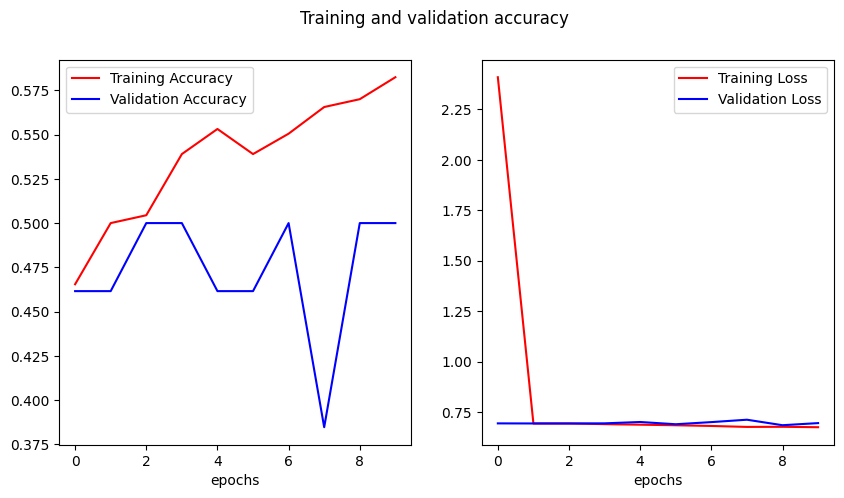

In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

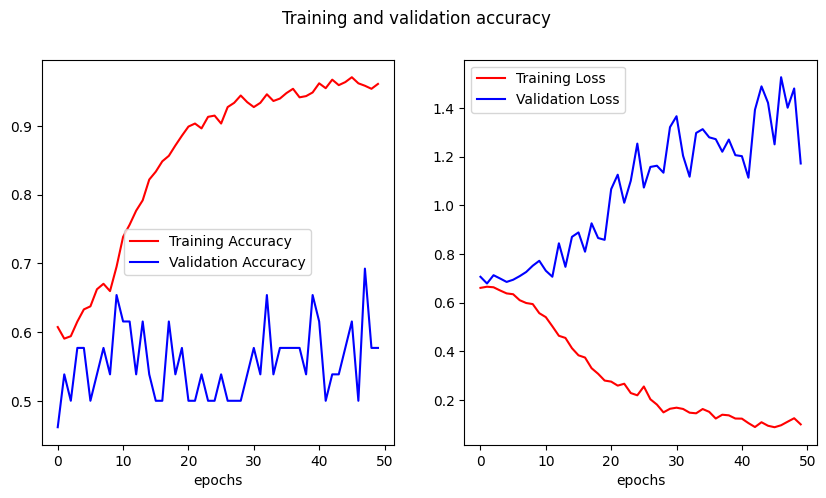

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Load the .h5 model
model = load_model("/content/compatible_fashion_v1.h5")
print("Model loaded from model.h5")

def prepare_input(image_path_upper, image_path_bottom):
    image = tf.io.read_file(image_path_upper)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0

    image1 = tf.io.read_file(image_path_bottom)
    image1 = tf.image.decode_jpeg(image1, channels=3)
    image1 = tf.image.resize(image1, (224, 224))
    image1 = image1 / 255.0

    return {"image1_input": tf.expand_dims(image, axis=0), "image2_input": tf.expand_dims(image1, axis=0)}

image_path_upper = "/content/drive/MyDrive/OutfitCompability/data/images/101830913/1.jpg"
image_path_bottom = "/content/drive/MyDrive/OutfitCompability/data/images/103867717/2.jpg"

input_tensor = prepare_input(image_path_upper, image_path_bottom)

predictions = model.predict(input_tensor)
predicted_class = 1 if predictions[0][0] >= 0.50 else 0

print("Predictions:", predictions)
print("Predicted Class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Predictions: [[0.6002712]]
Predicted Class: 1


In [ ]:
model.save("compatible_fashion_v1.h5")

In [ ]:
from tensorflow.keras.models import load_model

# Load the .h5 model
model = load_model("/content/compatible_fashion_v1.h5")
print("Model loaded from model.h5")

Model loaded from model.h5


In [ ]:
import pickle

In [ ]:
# Save the model
with open("tf_model.pkl", "wb") as file:
    pickle.dump(model, file)

print("TensorFlow model saved to tf_model.pkl")

TensorFlow model saved to tf_model.pkl
